# Import Library and Load Data

In [1]:
!pip install opencv-contrib-python tensorflow

import numpy as np, matplotlib.pyplot as plt, seaborn as sns, cv2, cv2.ximgproc, os, math, pandas as pd
from pathlib import Path
from collections import Counter
from scipy.ndimage import label as scipy_label

# Machine Learning & Metrics
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Deep Learning (ANN) - TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# GPU Configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reduce TensorFlow logging
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU terdeteksi: {len(gpus)} GPU")
    except RuntimeError as e:
        print(f"⚠️ GPU setup error: {e}")
else:
    print("⚠️ No GPU detected, using CPU")

# Feature Extractors
from skimage.feature import local_binary_pattern, hog

import warnings
warnings.filterwarnings('ignore')

# Konfigurasi Plotting
plt.style.use('seaborn-v0_8-whitegrid')
print("Libraries berhasil diimpor")

✅ GPU terdeteksi: 1 GPU
Libraries berhasil diimpor


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Path diatur ke: /content/drive/MyDrive/PBL/dataset/New-Data
Membaca direktori...
  -> Loading Bad Quality Carrot: 691 images
  -> Loading Bad Quality Potato: 260 images
  -> Loading Bad Quality Tomato: 288 images
  -> Loading Good Quality Carrot: 347 images
  -> Loading Good Quality Potato: 217 images
  -> Loading Good Quality Tomato: 427 images

Total Gambar Dimuat: 2230

Jumlah data per kualitas:
- Rusak: 1239 gambar
- Utuh: 991 gambar


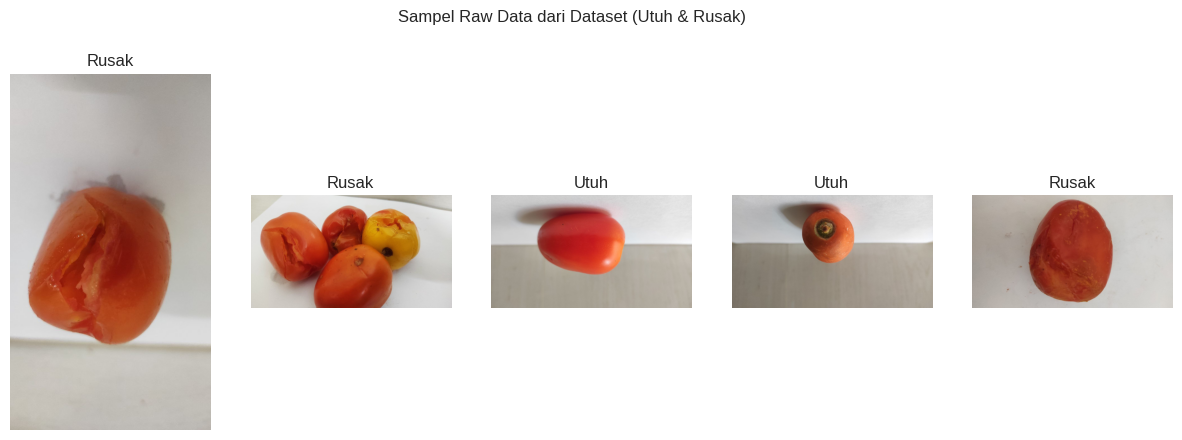

In [2]:
# ==========================================
# STEP 1: LOAD DATA & VISUALISASI RAW DATA
# ==========================================

from google.colab import drive
drive.mount('/content/drive')

# Format folder harus: "Bad Quality Potato", "Good Quality Carrot", dsb.
dataset_path = Path(r"/content/drive/MyDrive/PBL/dataset/New-Data")

print(f"Dataset Path diatur ke: {dataset_path}")

def parse_folder_info(folder_name):
    # Mengekstrak label utuh dan rusak
    name_lower = folder_name.lower()

    # Deteksi Kualitas
    quality = "Utuh" if "good" in name_lower else ("Rusak" if "bad" in name_lower else None)

    return quality

raw_images = [] # This will now store file paths
labels_quality = []

if dataset_path.exists():
    print("Membaca direktori...")
    for folder in sorted(dataset_path.iterdir()):
        if folder.is_dir():
            # Now parse_folder_info only returns 'qual'
            qual = parse_folder_info(folder.name)
            # We no longer need 'vtype' in this step for labels_type
            if qual:
                # Ambil semua ekstensi gambar
                files = list(folder.glob("*.jpg")) + list(folder.glob("*.png")) + list(folder.glob("*.jpeg"))
                print(f"  -> Loading {folder.name}: {len(files)} images")

                for f in files:
                    # Store file path instead of the image data to save RAM
                    raw_images.append(f)
                    labels_quality.append(qual)
else:
    print("Error: Path tidak ditemukan!")

print(f"\nTotal Gambar Dimuat: {len(raw_images)}")

# Menghitung jumlah 'Utuh' dan 'Rusak'
label_counts = Counter(labels_quality)
print("\nJumlah data per kualitas:")
for label, count in label_counts.items():
    print(f"- {label}: {count} gambar")

# ==================================================
#              VISUALISASI SAMPEL
# ==================================================
if len(raw_images) > 0:
    # Pisahkan indeks untuk 'Utuh' dan 'Rusak'
    utuh_indices = [i for i, label in enumerate(labels_quality) if label == 'Utuh']
    rusak_indices = [i for i, label in enumerate(labels_quality) if label == 'Rusak']

    selected_indices = []
    # Ambil 2 sampel 'Utuh'
    if len(utuh_indices) >= 2:
        selected_indices.extend(np.random.choice(utuh_indices, 2, replace=False))
    elif len(utuh_indices) > 0:
        selected_indices.extend(utuh_indices)

    # Ambil 3 sampel 'Rusak' atau sisanya jika 'Utuh' tidak cukup
    num_rusak_to_take = 5 - len(selected_indices)
    if len(rusak_indices) >= num_rusak_to_take:
        selected_indices.extend(np.random.choice(rusak_indices, num_rusak_to_take, replace=False))
    elif len(rusak_indices) > 0:
        selected_indices.extend(rusak_indices)

    # Shuffle the selected indices to mix 'Utuh' and 'Rusak'
    np.random.shuffle(selected_indices)

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(selected_indices):
        if i >= 5: # Limit to 5 plots even if more were selected due to small categories
            break
        plt.subplot(1, 5, i+1)
        # Load image on demand for visualization
        img_to_show = cv2.imread(str(raw_images[idx]))
        if img_to_show is not None:
            img_to_show = cv2.cvtColor(img_to_show, cv2.COLOR_BGR2RGB)
            plt.imshow(img_to_show)
        else:
            # Handle case where image could not be loaded
            plt.text(0.5, 0.5, "Image Error", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title(labels_quality[idx]) # Menambahkan label kualitas pada judul
        plt.axis('off')
    plt.suptitle("Sampel Raw Data dari Dataset (Utuh & Rusak)")
    plt.show()

# Preprocessing

Memulai Preprocessing...
Total preprocessed image = 2230

====== HASIL PSNR ======
Rata-rata : 38.33 dB
Minimum   : 27.69 dB
Maksimum  : 46.27 dB



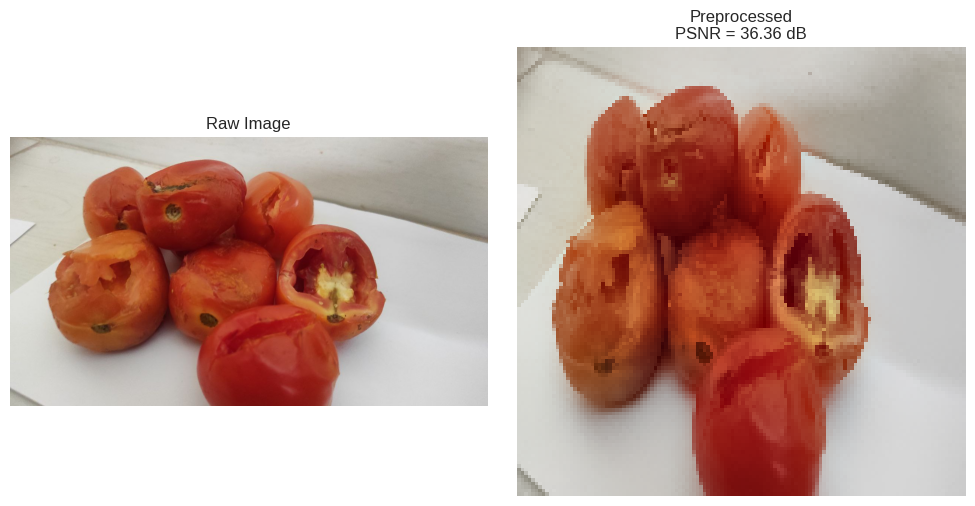

In [3]:
# ===================================================
# STEP 2: PREPROCESSING (Resize + Guided Filter)
# ===================================================

def calculate_psnr(original, processed):
    mse = np.mean((original.astype("float") - processed.astype("float")) ** 2)
    if mse == 0:
        return 100
    return 20 * math.log10(255.0 / math.sqrt(mse))


def resize_image(img, size=128):
    return cv2.resize(img, (size, size))


def guided_filter_smoothing(img_rgb, radius, eps):
    img_float = img_rgb.astype(np.float32) / 255.0
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY).astype(np.float32) / 255.0

    channels = []
    for c in range(3):
        ch = img_float[:, :, c]
        ch_filt = cv2.ximgproc.guidedFilter(guide=gray, src=ch, radius=radius, eps=eps)
        channels.append(ch_filt)

    smoothed = np.stack(channels, axis=2)
    return np.clip(smoothed * 255.0, 0, 255).astype(np.uint8)


# ======================================================================
#                   PREPROCESSING (NO AUGMENTATION)
# ======================================================================

preprocessed_images = []
psnr_after = []

print("Memulai Preprocessing...")

for img_path in raw_images:

    img = cv2.imread(str(img_path))
    if img is None:
        print(f"[SKIP] Error loading: {img_path}")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize
    orig_r = resize_image(img, 128)

    # Guided filter
    den_r = guided_filter_smoothing(orig_r, radius=5, eps=1e-4)

    # Simpan 1x saja
    preprocessed_images.append(den_r)

    # PSNR
    psnr_after.append(calculate_psnr(orig_r, den_r))


print(f"Total preprocessed image = {len(preprocessed_images)}")

print("\n====== HASIL PSNR ======")
print(f"Rata-rata : {np.mean(psnr_after):.2f} dB")
print(f"Minimum   : {np.min(psnr_after):.2f} dB")
print(f"Maksimum  : {np.max(psnr_after):.2f} dB")
print("========================\n")

# ==========================================
# VISUALISASI PREPROCESSING
# ==========================================

idx = np.random.randint(0, len(preprocessed_images))

raw_img = cv2.imread(str(raw_images[idx]))
raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)

prep_img = preprocessed_images[idx]
psnr_val = calculate_psnr(resize_image(raw_img, 128), prep_img)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(raw_img)
plt.title("Raw Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(prep_img)
plt.title(f"Preprocessed\nPSNR = {psnr_val:.2f} dB")
plt.axis("off")

plt.tight_layout()
plt.show()


# Segmentation and Augmentation

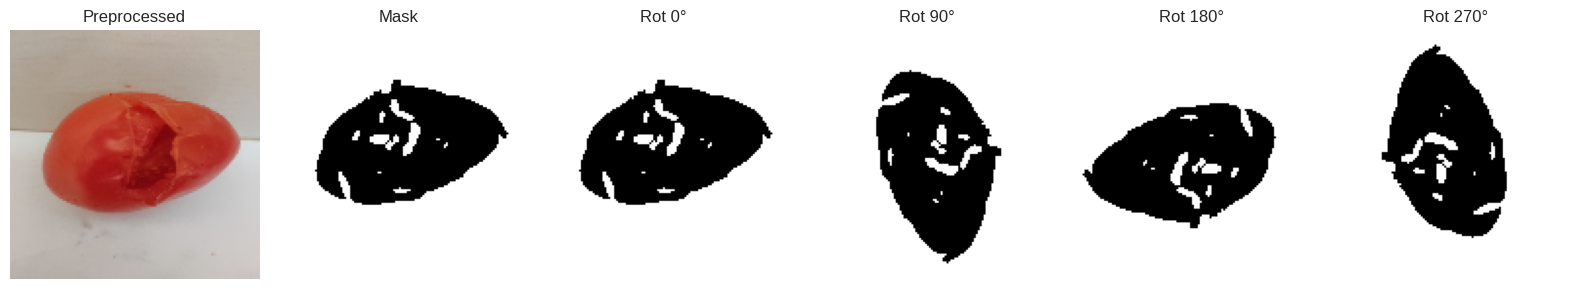

Jumlah citra asli              : 2230
Augmentasi per citra           : 4
Total citra setelah augmentasi : 8920


In [4]:
# ===================================================
# STEP 3: IMAGE SEGMENTATION + MASK AUGMENTASI
# ===================================================

def segmentation(preprocessed_img):
    # Kernel based on article
    Kh = np.array([
        [ 2, 1, 1, 1, -1, -1, -2],
        [ 2, 1, 1, 1, -1, -1, -2],
        [ 2, 1, 1, 1, -1, -1, -2],
        [ 2, 1, 1, 1, -1, -1, -2],
        [ 2, 1, 1, 1, -1, -1, -2],
        [ 2, 1, 1, 1, -1, -1, -2],
        [ 2, 1, 1, 1, -1, -1, -2]
    ], np.float32)

    Kv = np.array([
        [-2,-2,-2,-2,-2,-2,-2],
        [-1,-1,-1,-1,-1,-1,-1],
        [-1,-1,-1,-1,-1,-1,-1],
        [ 1, 1, 1, 1, 1, 1, 1],
        [ 1, 1, 1, 1, 1, 1, 1],
        [ 1, 1, 1, 1, 1, 1, 1],
        [ 2, 2, 2, 2, 2, 2, 2],
    ], np.float32)

    # 1. Convert to grayscale
    gray = cv2.cvtColor(preprocessed_img, cv2.COLOR_RGB2GRAY).astype(np.float32)

    # 2. Convolution
    Gh = cv2.filter2D(gray, -1, Kh)
    Gv = cv2.filter2D(gray, -1, Kv)

    # 3. Select max gradient magnitude
    Gmag = np.maximum(np.abs(Gh), np.abs(Gv))
    Gmag_norm = cv2.normalize(Gmag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # 4. Threshold
    _, mask = cv2.threshold(Gmag_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return mask

# -------- MASK AUGMENTASI (0°, 90°, 180°, 270°) --------
def augment_mask(mask):
    mask = mask.astype(np.uint8)
    return [
        mask,  # 0°
        cv2.rotate(mask, cv2.ROTATE_90_CLOCKWISE),           # 90°
        cv2.rotate(mask, cv2.ROTATE_180),                    # 180°
        cv2.rotate(mask, cv2.ROTATE_90_COUNTERCLOCKWISE)     # 270°
    ]

# Buat aug_masks untuk semua citra
all_aug_masks = []
for img in preprocessed_images:
    mask = segmentation(img)          # mask hasil segmentasi citra
    masks = augment_mask(mask)        # list 4 rotasi
    all_aug_masks.append(masks)       # all_aug_masks[i][j] = mask citra ke-i rotasi ke-j

# ===================================================
# VISUALISASI SEGMENTASI + AUGMENTASI MASK (contoh 1 citra)
# ===================================================
idx = np.random.randint(0, len(preprocessed_images))
prep = preprocessed_images[idx]
mask = segmentation(prep)
aug_masks = augment_mask(mask)

plt.figure(figsize=(16, 6))
plt.subplot(1, 6, 1)
plt.imshow(prep)
plt.title("Preprocessed")
plt.axis("off")

plt.subplot(1, 6, 2)
plt.imshow(mask, cmap="gray")
plt.title("Mask")
plt.axis("off")

titles = ["Rot 0°", "Rot 90°", "Rot 180°", "Rot 270°"]
for i, am in enumerate(aug_masks):
    plt.subplot(1, 6, i+3)
    plt.imshow(am, cmap="gray")
    plt.title(titles[i])
    plt.axis("off")

plt.tight_layout()
plt.show()

# ===================================================
# GENERATE X_data & y_qual_aug UNTUK SEMUA CITRA
# ===================================================
augment_angles = [0, 90, 180, 270]

# X_data = list of (index gambar, rotasi)
X_data = [(idx, angle) for idx in range(len(preprocessed_images)) for angle in augment_angles]

# y_qual_aug = label per citra diulang sesuai jumlah augmentasi
y_qual_aug = [label for label in labels_quality for _ in augment_angles]

print("Jumlah citra asli              :", len(preprocessed_images))
print("Augmentasi per citra           :", len(augment_angles))
print("Total citra setelah augmentasi :", len(X_data))

# Feature Extraction

In [5]:
# ==========================================
# STEP 4: FEATURE EXTRACTION (HOG + LTP + CLBP + CCV)
# Menggunakan segmentasi + augmentasi untuk semua fitur
# ==========================================

def get_augmented_image(img, angle):
    """Rotate image sesuai rotasi yang diberikan (0, 90, 180, 270)."""
    if angle == 0:
        return img
    elif angle == 90:
        return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    elif angle == 180:
        return cv2.rotate(img, cv2.ROTATE_180)
    elif angle == 270:
        return cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    return img

def compute_ccv_hsv(image, mask, bins=(8,8,8), tau=20):
    """CCV asli di HSV hanya di area mask (coherent vs incoherent)."""
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    mask_bool = mask.astype(bool)
    h = hsv[:,:,0][mask_bool]
    s = hsv[:,:,1][mask_bool]
    v = hsv[:,:,2][mask_bool]

    # Quantize
    h_bins = np.linspace(0, 180, bins[0]+1)
    s_bins = np.linspace(0, 256, bins[1]+1)
    v_bins = np.linspace(0, 256, bins[2]+1)

    h_idx = np.digitize(h, h_bins) - 1
    s_idx = np.digitize(s, s_bins) - 1
    v_idx = np.digitize(v, v_bins) - 1

    total_bins = bins[0]*bins[1]*bins[2]
    coherent = np.zeros(total_bins)
    incoherent = np.zeros(total_bins)

    # label_map 2D untuk connected component
    label_map = np.zeros(mask_bool.shape, dtype=int)
    label_map[mask_bool] = np.arange(np.sum(mask_bool)) + 1

    for hi in range(bins[0]):
        for si in range(bins[1]):
            for vi in range(bins[2]):
                bin_mask_flat = (h_idx == hi) & (s_idx == si) & (v_idx == vi)
                if not np.any(bin_mask_flat):
                    continue
                bin_mask_2d = np.zeros(mask_bool.shape, dtype=bool)
                bin_mask_2d[mask_bool] = bin_mask_flat
                labeled, num_features = scipy_label(bin_mask_2d)
                sizes = np.array([np.sum(labeled==i) for i in range(1, num_features+1)])
                coherent_pixels = np.sum(sizes[sizes>=tau])
                incoherent_pixels = np.sum(sizes[sizes<tau])
                bin_idx = hi*bins[1]*bins[2] + si*bins[2] + vi
                coherent[bin_idx] = coherent_pixels
                incoherent[bin_idx] = incoherent_pixels

    ccv_vector = np.concatenate([coherent, incoherent])
    ccv_vector = ccv_vector / (ccv_vector.sum() + 1e-6)
    return ccv_vector

def extract_features_with_mask(image, mask):
    """Ekstrak fitur HOG, LTP, CLBP, dan CCV dari citra dengan mask."""
    # Resize mask agar sesuai citra
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    mask_resized = cv2.resize(mask, (gray.shape[1], gray.shape[0]), interpolation=cv2.INTER_NEAREST)
    mask_resized = mask_resized.astype(np.uint8)

    # Masked grayscale untuk HOG, LTP, CLBP
    gray_masked = cv2.bitwise_and(gray, gray, mask=mask_resized)

    # 1. HOG
    fd_hog = hog(gray_masked, orientations=9, pixels_per_cell=(8,8),
                 cells_per_block=(2,2), visualize=False)

    # 2. LTP Approx (LBP Uniform)
    radius, n_points = 1, 8
    lbp = local_binary_pattern(gray_masked, n_points, radius, method='uniform')
    hist_ltp, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points+3), range=(0,n_points+2))
    hist_ltp = hist_ltp.astype(float)
    hist_ltp /= (hist_ltp.sum()+1e-6)

    # 3. CLBP Approx
    mean_val = np.mean(gray_masked)
    var_val = np.var(gray_masked)
    feat_clbp = np.append(hist_ltp, [mean_val, var_val])

    # 4. CCV HSV asli
    ccv_feat = compute_ccv_hsv(image, mask_resized, bins=(8,8,8), tau=50)

    # Gabungkan semua fitur
    return np.hstack([fd_hog, hist_ltp, feat_clbp, ccv_feat])

# ==========================================
# Ambil fitur untuk semua citra + augmentasi
# ==========================================
X_features = []

print("Mengekstrak fitur (HOG, LTP, CLBP menggunakan mask, CCV dari RGB, semua augmentasi)...")
X_features = []

for k, (orig_idx, rot_angle) in enumerate(X_data):
    img_proc = preprocessed_images[orig_idx]

    # Ambil mask augmentasi
    rot_idx = augment_angles.index(rot_angle)
    mask_aug = all_aug_masks[orig_idx][rot_idx]

    # Rotate citra sesuai rotasi
    img_aug = get_augmented_image(img_proc, rot_angle)

    # Ekstrak fitur
    feats = extract_features_with_mask(img_aug, mask_aug)
    X_features.append(feats)

    if (k+1) % 500 == 0:
        print(f"  -> Processed {k+1}/{len(X_data)}")

X_features = np.array(X_features)
print(f"Feature shape = {X_features.shape}")

Mengekstrak fitur (HOG, LTP, CLBP menggunakan mask, CCV dari RGB, semua augmentasi)...
  -> Processed 500/8920
  -> Processed 1000/8920
  -> Processed 1500/8920
  -> Processed 2000/8920
  -> Processed 2500/8920
  -> Processed 3000/8920
  -> Processed 3500/8920
  -> Processed 4000/8920
  -> Processed 4500/8920
  -> Processed 5000/8920
  -> Processed 5500/8920
  -> Processed 6000/8920
  -> Processed 6500/8920
  -> Processed 7000/8920
  -> Processed 7500/8920
  -> Processed 8000/8920
  -> Processed 8500/8920
Feature shape = (8920, 9146)


# Encoding, Split Data, Scaling

In [6]:
# ================================================
# STEP 5 — ENCODING, SPLIT DATA, SCALING
# ================================================

# Encode labels
le_qual = LabelEncoder()
y_qual_enc = le_qual.fit_transform(y_qual_aug)

# Prepare indices to map features back to images for visualization
indices = np.arange(len(X_features))

# # LANGKAH 1: Split 20% (train) / 40% (val) / 40% (test)
# X_train, X_temp, y_train, y_temp, idx_train, idx_temp = train_test_split(
#     X_features, y_qual_enc, indices, test_size=0.80,
#     random_state=42, stratify=y_qual_enc)

# X_val, X_test, y_val, y_test, idx_val, idx_test = train_test_split(
#     X_temp, y_temp, idx_temp, test_size=0.50,
#     random_state=42, stratify=y_temp)

# SPLIT 30:70
# # LANGKAH 1: Split 30% / 35% / 35%
# X_train, X_temp, y_train, y_temp, idx_train, idx_temp = train_test_split(
#     X_features, y_qual_enc, indices, test_size=0.70,
#     random_state=42, stratify=y_qual_enc)

# X_val, X_test, y_val, y_test, idx_val, idx_test = train_test_split(
#     X_temp, y_temp, idx_temp, test_size=0.50,
#     random_state=42, stratify=y_temp)


# SPLIT 40:60
# # LANGKAH 1: Split 40% / 30% / 30%
# X_train, X_temp, y_train, y_temp, idx_train, idx_temp = train_test_split(
#     X_features, y_qual_enc, indices, test_size=0.60,
#     random_state=42, stratify=y_qual_enc)

# X_val, X_test, y_val, y_test, idx_val, idx_test = train_test_split(
#     X_temp, y_temp, idx_temp, test_size=0.50,
#     random_state=42, stratify=y_temp)


# SPLIT 50:50
# LANGKAH 1: Split 50% / 25% / 25%
X_train, X_temp, y_train, y_temp, idx_train, idx_temp = train_test_split(
    X_features, y_qual_enc, indices, test_size=0.50,
    random_state=42, stratify=y_qual_enc)

X_val, X_test, y_val, y_test, idx_val, idx_test = train_test_split(
    X_temp, y_temp, idx_temp, test_size=0.50,
    random_state=42, stratify=y_temp)


# SPLIT 70:30
# # LANGKAH 1: Split 70% / 15% / 15%
# X_train, X_temp, y_train, y_temp, idx_train, idx_temp = train_test_split(
#     X_features, y_qual_enc, indices, test_size=0.30,
#     random_state=42, stratify=y_qual_enc)

# X_val, X_test, y_val, y_test, idx_val, idx_test = train_test_split(
#     X_temp, y_temp, idx_temp, test_size=0.50,
#     random_state=42, stratify=y_temp)


# SPLIT 80:20
# # LANGKAH 1: Split 80% / 10% / 10%
# X_train, X_temp, y_train, y_temp, idx_train, idx_temp = train_test_split(
#     X_features, y_qual_enc, indices, test_size=0.20,
#     random_state=42, stratify=y_qual_enc)

# X_val, X_test, y_val, y_test, idx_val, idx_test = train_test_split(
#     X_temp, y_temp, idx_temp, test_size=0.50,
#     random_state=42, stratify=y_temp)


# SPLIT 90:10
# # LANGKAH 1: Split 90% / 5% / 5%
# X_train, X_temp, y_train, y_temp, idx_train, idx_temp = train_test_split(
#     X_features, y_qual_enc, indices, test_size=0.10,
#     random_state=42, stratify=y_qual_enc)

# X_val, X_test, y_val, y_test, idx_val, idx_test = train_test_split(
#     X_temp, y_temp, idx_temp, test_size=0.50,
#     random_state=42, stratify=y_temp)

print("Data Split:")
print(f"  Train: {X_train.shape}")
print(f"  Val:   {X_val.shape}")
print(f"  Test:  {X_test.shape}")

# LANGKAH 2: Scaling (FIT hanya pada training set!)
print("\nApplying StandardScaler...")
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)  # FIT + TRANSFORM pada train
X_val_s   = scaler.transform(X_val)        # Hanya TRANSFORM pada val
X_test_s  = scaler.transform(X_test)       # Hanya TRANSFORM pada test

print("Scaling completed")

Data Split:
  Train: (4460, 9146)
  Val:   (2230, 9146)
  Test:  (2230, 9146)

Applying StandardScaler...
Scaling completed


# ANN Clasification

Training and validation


MODEL ARCHITECTURE


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │     1,170,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,181,986 (4.51 MB)

 Trainable params: 1,181,602 (4.51 MB)

 Non-trainable params: 384 (1.50 KB)


Training ANN dengan GPU...
Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.5709 - loss: 4.4335 - val_accuracy: 0.7637 - val_loss: 3.0715 - learning_rate: 0.0010
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7326 - loss: 2.8292 - val_accuracy: 0.8166 - val_loss: 2.0879 - learning_rate: 0.0010
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7997 - loss: 1.9664 - val_accuracy: 0.8202 - val_loss: 1.6465 - learning_rate: 0.0010
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8526 - loss: 1.5105 - val_accuracy: 0.8170 - val_loss: 1.4586 - learning_rate: 0.0010
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8589 - loss: 1.3514 - val_accuracy: 0.8161 - val_loss: 1.3241 - learning_rate: 0.0010
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8657 - loss: 1.1987 - val_accuracy: 0.8480 - val_loss: 1.1749 - learning_rate: 0.0010
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

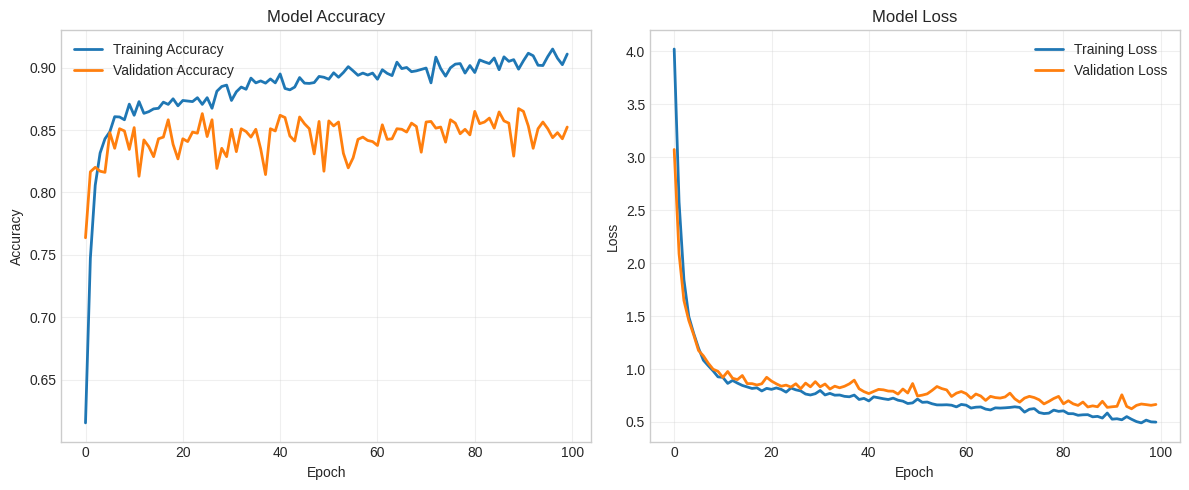

Best Epoch: 95
Training Accuracy: 90.18%
Validation Accuracy: 85.65%
Gap: 4.53%
✅ Good Fitting: Model memiliki generalisasi yang baik.


In [7]:
# =================================================
# STEP 6 — TRAINING ANN (UTUH vs RUSAK) DENGAN GPU
# =================================================

model_ann = Sequential([
    Input(shape=(X_train_s.shape[1],)),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.2),

    Dense(len(le_qual.classes_), activation='softmax')
])

# Compile model dengan best learning rate
model_ann.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\n" + "="*50)
print("MODEL ARCHITECTURE")
print("="*50)
model_ann.summary()

# Define callbacks untuk early stopping dan learning rate reduction
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6, verbose=1)
]

print("\nTraining ANN dengan GPU...")
print("="*50)

# Train model
with tf.device('/GPU:0' if gpus else '/CPU:0'):
    history = model_ann.fit(
        X_train_s, y_train,
        validation_data=(X_val_s, y_val),
        epochs=100,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )

print("\n" + "="*50)
print("TRAINING COMPLETED")
print("="*50)

# Evaluasi pada training set
print("\nEvaluasi Training Set:")
train_loss, train_acc = model_ann.evaluate(X_train_s, y_train, verbose=0)
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_acc*100:.2f}%")

# Get predictions untuk classification report (training)
y_train_pred = np.argmax(model_ann.predict(X_train_s, verbose=0), axis=1)
print("\n" + classification_report(y_train, y_train_pred, target_names=le_qual.classes_))

# Evaluasi pada validation set
print("\nEvaluasi Validation Set:")
val_loss, val_acc = model_ann.evaluate(X_val_s, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc*100:.2f}%")

# Get predictions untuk classification report (validation)
y_val_pred = np.argmax(model_ann.predict(X_val_s, verbose=0), axis=1)
print("\n" + classification_report(y_val, y_val_pred, target_names=le_qual.classes_))

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ===================================================
# DIAGNOSA OVERFITTING / UNDERFITTING
# ===================================================
best_epoch = np.argmin(history.history['val_loss'])

best_train_acc = history.history['accuracy'][best_epoch]
best_val_acc = history.history['val_accuracy'][best_epoch]
gap = best_train_acc - best_val_acc

print(f"Best Epoch: {best_epoch+1}")
print(f"Training Accuracy: {best_train_acc*100:.2f}%")
print(f"Validation Accuracy: {best_val_acc*100:.2f}%")
print(f"Gap: {gap*100:.2f}%")

if gap > 0.10:
    print("⚠️ Overfitting: Model terlalu menyesuaikan data training.")
elif best_train_acc < 0.70 and best_val_acc < 0.70:
    print("⚠️ Underfitting: Model belum mampu mempelajari pola data.")
else:
    print("✅ Good Fitting: Model memiliki generalisasi yang baik.")

Best Epoch: 95


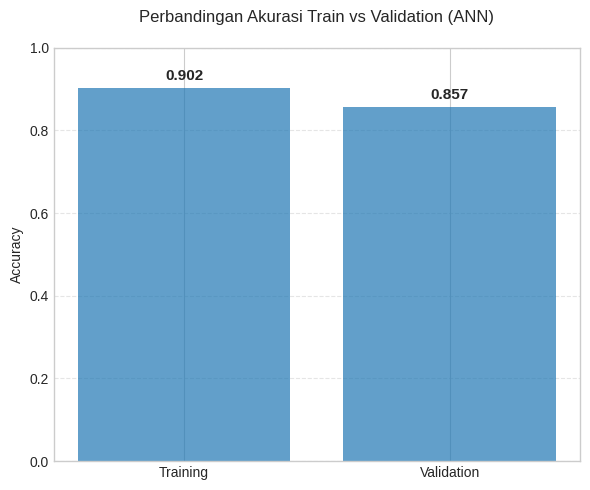


Evaluasi Training vs Validation (ANN)
Training Accuracy   : 0.9018
Validation Accuracy : 0.8565
Gap (Train - Val)   : 0.0453
✅ Good Fitting: Model memiliki generalisasi yang baik.


In [8]:
# ===================================================
# EVALUASI TRAIN vs VALIDATION (ANN) - BEST EPOCH
# ===================================================

# Ambil epoch terbaik berdasarkan validation loss
best_epoch = np.argmin(history.history['val_loss'])

train_acc_best = history.history['accuracy'][best_epoch]
val_acc_best   = history.history['val_accuracy'][best_epoch]
gap_tv = train_acc_best - val_acc_best

print(f"Best Epoch: {best_epoch + 1}")

# Simpan akurasi
acc = {
    "Training": train_acc_best,
    "Validation": val_acc_best
}

# ===================================================
# Visualisasi (Bar Chart)
# ===================================================
plt.figure(figsize=(6, 5))
plt.bar(acc.keys(), acc.values(), alpha=0.7)

plt.title("Perbandingan Akurasi Train vs Validation (ANN)\n")
plt.ylabel("Accuracy")
plt.ylim(0, 1)

# Label nilai
for i, value in enumerate(acc.values()):
    plt.text(i, value + 0.02, f"{value:.3f}",
             ha="center", fontsize=11, fontweight='bold')

plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# ===================================================
# Analisis Numerik
# ===================================================
print("\nEvaluasi Training vs Validation (ANN)")
print(f"Training Accuracy   : {train_acc_best:.4f}")
print(f"Validation Accuracy : {val_acc_best:.4f}")
print(f"Gap (Train - Val)   : {gap_tv:.4f}")

# ===================================================
# Diagnosa Model
# ===================================================
if gap_tv > 0.10:
    print("⚠️ Overfitting: Model terlalu menyesuaikan data training.")
elif train_acc_best < 0.70 and val_acc_best < 0.70:
    print("⚠️ Underfitting: Model belum mampu mempelajari pola data.")
else:
    print("✅ Good Fitting: Model memiliki generalisasi yang baik.")

Testing

Evaluating on Test Set...
Test Loss: 0.6242
Test Accuracy: 86.55%

Classification Report (Test Set):
              precision    recall  f1-score   support

       Rusak       0.88      0.88      0.88      1239
        Utuh       0.85      0.84      0.85       991

    accuracy                           0.87      2230
   macro avg       0.86      0.86      0.86      2230
weighted avg       0.87      0.87      0.87      2230

Ringkasan Prediksi (Test Set):
Total Samples   : 2230
Total Benar   : 1930
Total Salah     : 300


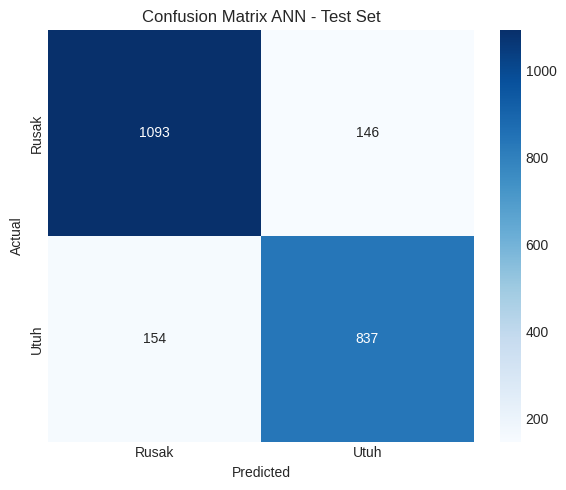

In [9]:
# ==========================================
# STEP 7 — TESTING ANN (UTUH vs RUSAK)
# ==========================================

print("Evaluating on Test Set...")
test_loss, test_acc = model_ann.evaluate(X_test_s, y_test, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%\n")

# Predictions
y_test_proba = model_ann.predict(X_test_s, verbose=0)
y_test_pred = np.argmax(y_test_proba, axis=1)

# Classification report
print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=le_qual.classes_))

# Ringkasan total prediksi benar vs salah
total_samples = len(y_test)
total_correct = int(np.sum(y_test_pred == y_test))
total_wrong = int(total_samples - total_correct)
print("Ringkasan Prediksi (Test Set):")
print(f"Total Samples   : {total_samples}")
print(f"Total Benar   : {total_correct}")
print(f"Total Salah     : {total_wrong}")

# Confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_test_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=le_qual.classes_,
            yticklabels=le_qual.classes_)
plt.title("Confusion Matrix ANN - Test Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Menampilkan 10 gambar test dengan prediksi...


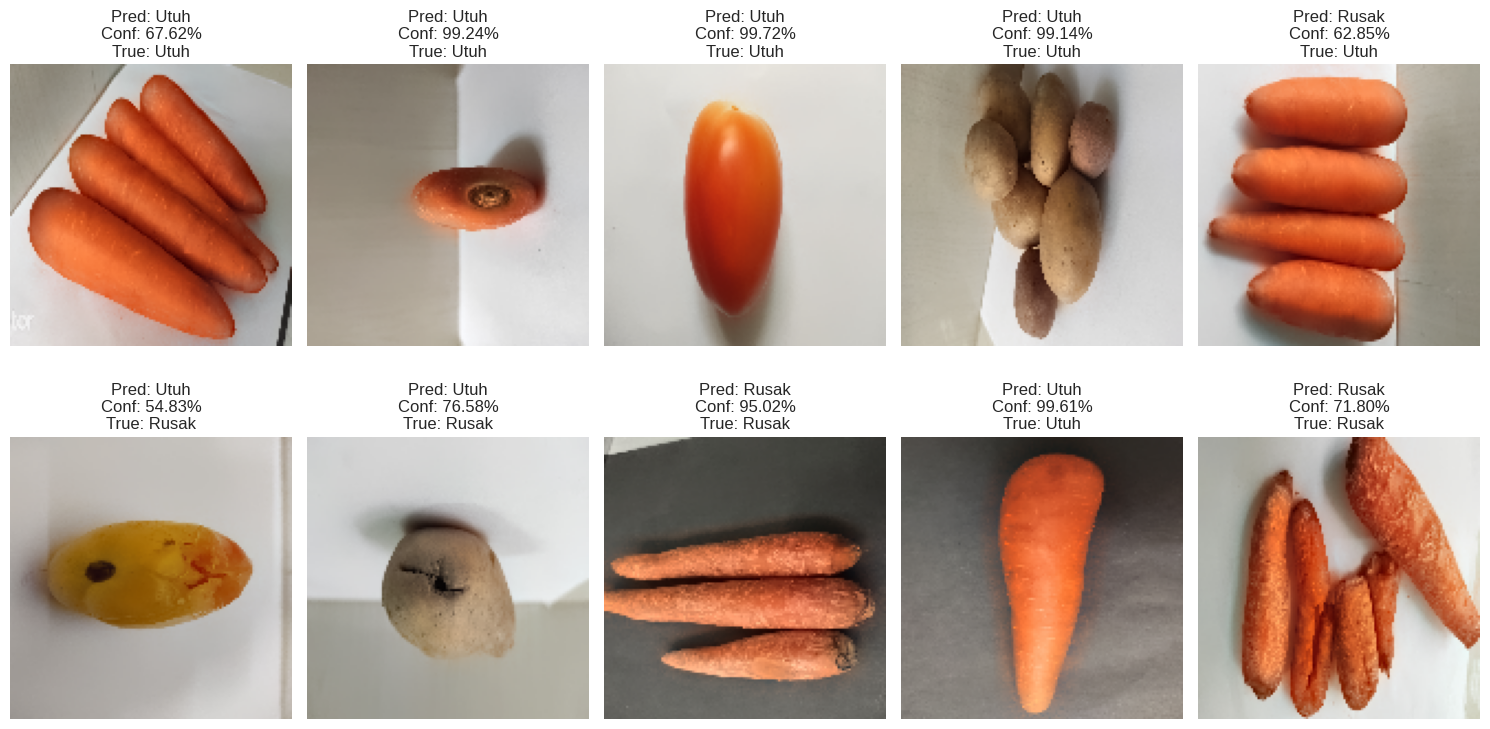

In [10]:
# ================================================
# OUTPUT KLASIFIKASI + CONFIDENCE (PROBABILITY)
# ================================================

# Ambil probabilitas
proba = model_ann.predict(X_test_s)

# Prediksi kelas
pred_labels = np.argmax(proba, axis=1)

# Confidence = probabilitas kelas yang diprediksi
confidence = np.max(proba, axis=1)

# Mapping kembali ke label asli
label_map = {i: cls for i, cls in enumerate(le_qual.classes_)}


print("\nMenampilkan 10 gambar test dengan prediksi...")

indices_to_show = np.random.choice(len(X_test), 10, replace=False)

plt.figure(figsize=(15, 8))

for i, idx_in_test_set in enumerate(indices_to_show):
    plt.subplot(2, 5, i+1)
    # Retrieve the original preprocessed image using idx_test
    original_image_index = idx_test[idx_in_test_set]

    # X_data berisi tuple (index, angle), ambil hanya index untuk mendapatkan gambar
    img_idx, angle = X_data[original_image_index]
    img_show = preprocessed_images[img_idx]

    # Rotate image sesuai angle untuk visualisasi
    img_show = get_augmented_image(img_show, angle)

    plt.imshow(img_show)

    cls = label_map[pred_labels[idx_in_test_set]]
    conf = confidence[idx_in_test_set] * 100
    true = label_map[y_test[idx_in_test_set]]

    plt.title(f"Pred: {cls}\nConf: {conf:.2f}%\nTrue: {true}")
    plt.axis("off")

plt.tight_layout()
plt.show()